# Task 3 : Deepfake detection through ensemble of CNNs


In [ ]:
!git clone https://github.com/polimi-ispl/icpr2020dfdc
!pip install efficientnet-pytorch
!pip install -U git+https://github.com/albu/albumentations > /dev/null
%cd icpr2020dfdc/notebook

fatal: destination path 'icpr2020dfdc' already exists and is not an empty directory.
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-qm2y5nzr
/content/icpr2020dfdc/notebook


In [ ]:
# Check if the Model is running on GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import torch
from torch.utils.model_zoo import load_url
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
from torchvision.transforms import ToPILImage

import sys
sys.path.append('..')

from blazeface import FaceExtractor, BlazeFace
from architectures import fornet,weights
from isplutils import utils
import pickle

## Parameters

In [ ]:
"""
Choose an architecture between
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
- Xception
"""
net_model = 'EfficientNetB4'

"""
Choose a training dataset between
- DFDC
- FFPP
"""
train_db = 'DFDC'

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

## Initialization

In [ ]:
model_url = weights.weight_url['{:s}_{:s}'.format(net_model,train_db)]
net = getattr(fornet,net_model)().eval().to(device)
net.load_state_dict(load_url(model_url,map_location=device,check_hash=True))

Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [ ]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [ ]:
facedet = BlazeFace().to(device)
facedet.load_weights("../blazeface/blazeface.pth")
facedet.load_anchors("../blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

In [ ]:
def load_and_dump(t_dir,ds_dir):
  X = []
  y = []  
  # Directories for real and fake datasets
  real_dir = os.path.join(t_dir,ds_dir,'real')
  fake_dir = os.path.join(t_dir,ds_dir,'fake')
  # For Real Images
  X_real,y_real = extractImgsWithLabels(real_dir,1)
  X.append(X_real)

  # For Fake Images
  X_fake,y_fake = extractImgsWithLabels(fake_dir,0)
  X.append(X_fake)

  # serializing the data into pickle files 
  with open(os.path.join(t_dir,'{}_imgs.pickle'.format(ds_dir)), 'wb') as f:
    pickle.dump(X, f) 
  print("Images are dumped as ","{}_imgs.pickle".format(ds_dir))
  print("Location for the Images binary file is ",t_dir)
  return X[0],X[1] # load the real and fake data

# Extracting features from face images
def loadDumpedDeepFake(t_dir,ds_dir):
  with open(os.path.join(t_dir,'{}_imgs.pickle'.format(ds_dir)), 'rb') as f:
    imgs = pickle.load(f) 
  print("Images are loaded from ","{}_imgs.pickle".format(ds_dir))
  print("Location for the Images binary file is ",t_dir)
  return imgs[0],imgs[1] # load the real and fake data

def extractImgsWithLabels(ds_fname,label):
  images = []
  labels = []
  print("Fetching Dataset from this path: ",ds_fname)
  videos_names = sorted(os.listdir(ds_fname))
  print("List of detected videos are : \n", videos_names)
  for video in videos_names:
      video_path = os.path.join(ds_fname,video)
      print("Current Loaded video is ", video_path)
      video_frames = Path(video_path).glob("*.jpg")
      for frame in video_frames:
        im=Image.open(frame)
        images.append(im)
        labels.append(label)
  print("Number of loaded Images :", len(images))
  return images,labels

  # Extracting features from face images
def loadDumpedDeepFake(t_dir,ds_dir):
  with open(os.path.join(t_dir,'{}_imgs.pickle'.format(ds_dir)), 'rb') as f:
    imgs = pickle.load(f) 
  print("Images are loaded from ","{}_imgs.pickle".format(ds_dir))
  print("Location for the Images binary file is ",t_dir)
  return imgs[0],imgs[1] # load the real and fake data

## Load images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image
from pathlib import Path
import numpy as np
import glob

proj_dir = "/content/drive/MyDrive/DeepFake_dataset"
db_dir = 'Task_2_3'
train_dir = 'development'
test_dir = 'evaluation'
t_dir = os.path.join(proj_dir,db_dir)

# Enter Project Directory
os.chdir(proj_dir)

# Extract dataset images
if os.path.exists(db_dir) :
  print("Dataset is ready !")
else:
  !unzip Task_2_3.zip
  print("Dataset Compression is done !")

Dataset is ready !


## Predict scores

In [ ]:
# Evaluate the dataset
from sklearn.metrics import roc_auc_score

X_real, X_fake = loadDumpedDeepFake(t_dir,test_dir)
y_test = len(X_real) * [0]
y_test.extend(len(X_fake) * [1])
X = X_real
X.extend(X_fake)


TotalPreds = []
for img in X:
  im_faces = face_extractor.process_image(img=img)
  im_face = im_faces['faces'][0]
  face_t = np.expand_dims(transf(image=im_face)['image'],0)
# faces_t = torch.stack( [ transf(image=im)['image'] for im in all_ds_face ] )
  with torch.no_grad():
    faces_pred = torch.sigmoid(net(torch.Tensor(face_t).to(device))).cpu().numpy().flatten()
  TotalPreds.append(faces_pred)

# AUC score
y_pred = TotalPreds 
roc_auc_score(y_test, y_pred)

Images are loaded from  evaluation_imgs.pickle
Location for the Images binary file is  /content/drive/MyDrive/DeepFake_dataset/Task_2_3


0.8919777777777778

The prediction score is : [0.01210007]


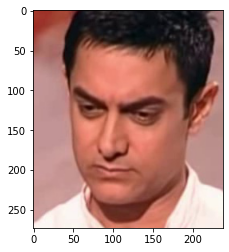

In [ ]:
im_faces = face_extractor.process_image(img=X[1])
im_face = im_faces['faces'][0]
face_t = np.expand_dims(transf(image=im_face)['image'],0)
with torch.no_grad():
  faces_pred = torch.sigmoid(net(torch.Tensor(face_t).to(device))).cpu().numpy().flatten()
plt.imshow(im_face)
print("The prediction score is :", faces_pred)

In [ ]:
len(TotalPreds)

600

In [ ]:
transf(image=im_face)['image'].shape

torch.Size([3, 224, 224])

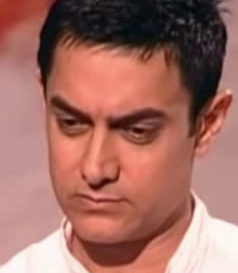

In [ ]:
Image.fromarray(im_face)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from math import sqrt
from sklearn.metrics import mean_squared_error, plot_confusion_matrix

def plot_roc_curve(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print('RMSE', rmse)
    
    FPR, TPR, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(FPR, TPR)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(FPR, TPR, label='AUC = %0.2f' % roc_auc)
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.ylabel('True Positive')
    plt.xlabel('False Positive')
    plt.show()

RMSE 0.36718322145266863


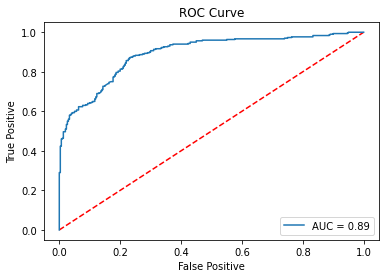

In [ ]:
plot_roc_curve(y_test, y_pred)